<strong>*Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org. Here, we will read in some gridded data and then plot DEMs*</strong>
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda)

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - numpy
    - geopandas: for creating geo-dataframes

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

<strong>1) Download Data:

If you have downloaded this notebook to your local drive, then you will also need to download some data. You can use this notebook to plot any CryoTEMPO-EOLIS gridded data that you choose. For a quick example, follow the below instructions to download a small example dataset.</strong>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Imports necessary to run the rest of the code

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import glob
import numpy as np
import matplotlib.dates as mdate
import geopandas
import datetime
import os
import platform
from ftplib import FTP
import sys

/home/dubbersophie/.conda/envs/ew_eolis/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


One of these packages is not present in the default Google Colab environment - we must install it ourselves

In [ ]:
pip install geopandas

<strong>The following four cells contain the python script necessary to download the results of the query described above from the ESA FTP servers. It is taken verbatim from the script generated by a cs2eo query - one could run said script in place of these 4 cells, for any query of your choice. The data is downloaded to your current working directory. This query will download 59 files containing point product data for Iceland.</strong>

These functions contain specific methods needed to complete the data download:

In [ ]:
def file_byte_handler(data):
    global download_file_obj, read_byte_count, total_byte_count
    download_file_obj.write(data)
    read_byte_count = read_byte_count + len(data)
    progress_bar(read_byte_count, total_byte_count)


def progress_bar(progress, total, prefix="", size=60, file=sys.stdout):
    if total != 0:
        x = int(size*progress/total)
        x_percent = int(100*progress/total)
        file.write(f" {prefix} [{'='*x}{' '*(size-x)}] {x_percent} % \r")
        file.flush()

First, we list the files that we want to download. These are generated automatically by a cs2eo.org query.

In [ ]:
esa_files =  ['/TEMPO_SWATH_GRID/2021/11/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2021_11_V001.nc', '/TEMPO_SWATH_GRID/2022/03/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2022_03_V001.nc', '/TEMPO_SWATH_GRID/2021/10/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2021_10_V001.nc', '/TEMPO_SWATH_GRID/2022/02/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2022_02_V001.nc', '/TEMPO_SWATH_GRID/2021/12/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2021_12_V001.nc', '/TEMPO_SWATH_GRID/2022/01/ICELAND/CS_OFFL_THEM_GRID__ICELAND___2022_01_V001.nc']
download_file_obj = None
read_byte_count = None
total_byte_count = None

Next, we must provide an email address to access the ESA FTP server. Input your email into the prompt that appears below.

In [ ]:
if int(platform.python_version_tuple()[0]) < 3:
    exit("Your Python version is {}. Please use version 3.0 or higher.".format(platform.python_version()))

email = input("Please enter your e-mail: ")

Finally, we connect to the server, supply our email address and download the data to our current working directory. This process should take a couple of minutes. The progress of the download will be shown below.

In [ ]:
print("About to connect to ESA science server")
# Open the FTP connection
with FTP("science-pds.cryosat.esa.int") as ftp:
    try:
        #Login using your email address
        ftp.login("anonymous", email)
        print("Downloading {} files".format(len(esa_files)))
        # Step through the files that we want to download    
        for i, filename in enumerate(esa_files):
            padded_count = str(i+1).zfill(len(str(len(esa_files))))
            # Print some details about the progress of the download
            print("{}/{}. Downloading file {}".format(padded_count, len(esa_files), os.path.basename(filename)))
            with open(os.path.basename(filename), 'wb') as download_file:
                download_file_obj = download_file
                total_byte_count = ftp.size(filename)
                read_byte_count = 0
                ftp.retrbinary('RETR ' + filename, file_byte_handler, 1024)
            print("\n")
    # After downloading all of the files, close the FTP connection
    finally:
        print("Exiting FTP.")
        ftp.quit()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
<strong>2) Load downloaded data into python</strong>

<strong>Now that we have downloaded the data, we can use python to visualise it. In the remainder of this demo notebook, we will load the data that we have just downloaded into python, and then use it to plot a series of DEMs showing the elevation of the Vatnajokull glacier.</strong> 

If you have downloaded the notebook onto your local machine, you will need to edit the filepath below to point to the location of the downloaded data. We will then locate and store the names of each of the point data files. The gridded data is stored in *netcdf* files, which have the suffix .nc
Here, we also define the coordinate reference system (CRS) for the region that we are plotting (Iceland), that describes the projection information for this geographical area. If you wish to plot a difference region, you may need to change the CRS definition to match the region, as described at https://cryotempo-eolis.org/products/

In [3]:
# Fill this filepath in with the location of the downloaded gridded data on your local system
data_filepath = '/home/dubbersophie/ew_code/extra_stuff_for_eolis_demo/gridded_data/'
region_crs = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' # Standard projection information for iceland
files = sorted(glob.glob(data_filepath+'/*.nc'))

<strong>Now that the files containing the data have been located, we will load the data that they contain into python, one file at a time.</strong>

In [4]:
dems, timestamp_list = [], []

 The following code opens each netcdf file, reads in the data associated with each variable, and stores this data in the column of a dataframe. Here we choose to extract the x and y positions, and the elevation value, of each gridcell within the gridded product. We then convert the pandas dataframe that contains the x,y and elevation data to a *geopandas* dataframe, which contains additional geospatial data that we need for plotting this grid of data.

In [5]:
for i in range(len(files)):
    # Open the netcdf file
    netcdf = nc.Dataset(files[i])
    # Store the 'time' variable as a list of timestamps
    time =  netcdf.variables['time']
    timestamp = time[:]
    data = {}
    dem, x_bnds, y_bnds = [], [], []
    for v in netcdf.variables:
        d = netcdf.variables[v]
        if len(d.shape) == 1:
            srs = pd.Series(d[:])
            data[v] = srs
        else:
            if v == 'elevation':
                dem.append(d[:])
            elif v == 'x_bnds':
                x_bnds.append(d[:])
            elif v == 'y_bnds':
                y_bnds.append(d[:])    
    
    dem[0][dem[0].mask] = np.nan

    xs = np.average(x_bnds[0].data, axis=1)
    ys = np.average(y_bnds[0].data, axis=1)
    yy, xx = np.meshgrid(ys, xs)
    df = pd.DataFrame()
    df['x'] = xx.flatten()
    df['y'] = yy.flatten()
    df['elevation'] = dem[0].data.reshape(len(xs), len(ys)).flatten()
    netcdf.close()
    
    timestamp_list.append(timestamp)
    gdf = geopandas.GeoDataFrame(df, crs=region_crs, geometry=geopandas.points_from_xy(df.x, df.y))
    dems.append(gdf)

Finally, we use the datetime python package to convert the *timestamps* provided by the EOLIS data into *years, months and days*

In [6]:
dates = [datetime.datetime.fromtimestamp(a[0]) for a in timestamp_list]    

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
<strong>3) Use the Cryotempo-EOLIS gridded product to plot a selection of DEMS, and show the difference in elevation for a specific time window</strong>

We will use the in-built plotting function for a geopandas dataframe, and plot the 2-dimensional elevation data for Vatnajokull. We will plot the first and last months returned in the 6-month window, and then the change in elevation between these two dates. 

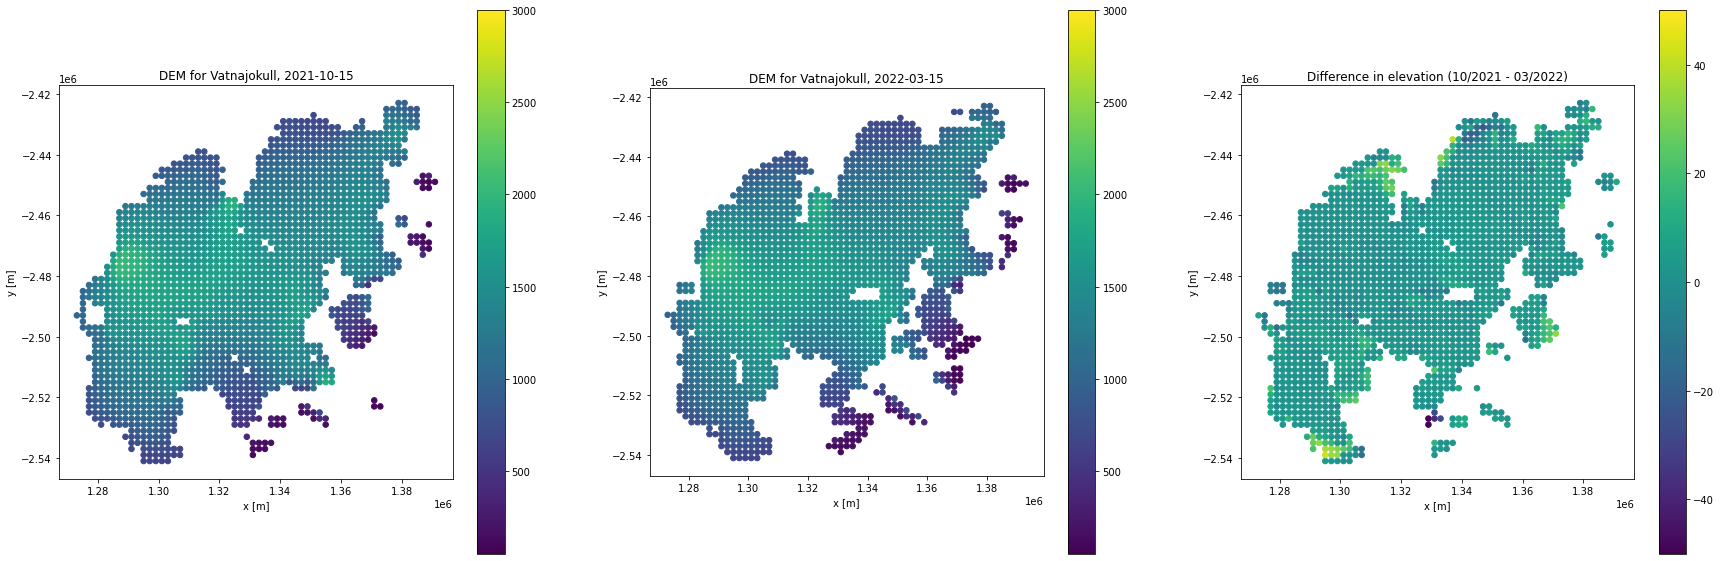

In [7]:

fig, axs = plt.subplots(1,3,figsize=(30, 10))
gdf1 = dems[0]
a = gdf.plot(ax=axs[0], column=gdf1['elevation'], markersize=30, cmap='viridis',vmin = 50,vmax = 3000, legend=True)
axs[0].set_title('DEM for Vatnajokull, '+str(dates[0].date()))
gdf2 = dems[-1]
b = gdf.plot(ax=axs[1], column=gdf2['elevation'], markersize=30, cmap='viridis',vmin = 50,vmax = 3000, legend=True)
axs[1].set_title('DEM for Vatnajokull, '+str(dates[-1].date()))

c = gdf.plot(ax=axs[2], column=gdf2['elevation']-gdf1['elevation'], markersize=30, cmap='viridis',vmin = -50,vmax = 50, legend=True)
axs[2].set_title('Difference in elevation (10/2021 - 03/2022)')

for i in range(len(axs)):
    axs[i].set_xlabel('x [m]')
    axs[i].set_ylabel('y [m]')